In [1]:
# !pip install ipywidgets

In [2]:
import numpy as np
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (
    RFE,
    SelectFromModel,
    SelectKBest,
    mutual_info_regression,
)
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
import pandas as pd
from src.data_loader import load_btcusdt_data
from src.feature_engineering import func_features
from src.models import func_train_model
from src.perfomance import func_model_performance
from src.visualisation import func_plot
import optuna

In [4]:
df = pd.read_csv('data/btcusdt_1h.csv', index_col='closeTime', parse_dates=True)
df['openTime'] = pd.to_datetime(df['openTime'], unit='ms')
df['predict'] = 1
df['return_next_class'] = np.where(df['return_next']>0,1,0)

In [5]:
df.head(2)

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,Ignore,return,return_next,predict,return_next_class
closeTime,,,,,,,,,,,,,,,
2022-01-01 00:59:59.999,2022-01-01 00:00:00,46216.93,46731.39,46208.37,46656.13,1503.33095,6.987999e+07,38608,806.06536,3.746216e+07,0,NaN,0.002615,1,1
2022-01-01 01:59:59.999,2022-01-01 01:00:00,46656.14,46949.99,46574.06,46778.14,943.81539,4.412715e+07,31872,491.18067,2.296327e+07,0,0.002615,0.000719,1,1


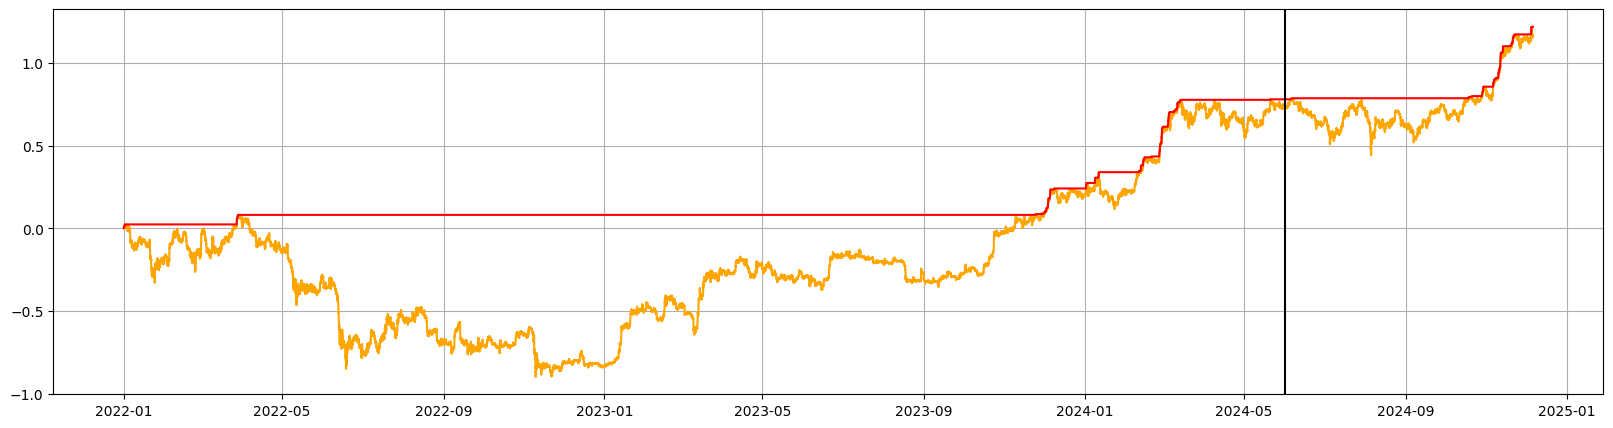

In [6]:
func_plot(df)

In [7]:
df.ta(kind='MACD',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
closeTime,,,
2022-01-01 00:59:59.999,NaN,NaN,NaN
2022-01-01 01:59:59.999,NaN,NaN,NaN
2022-01-01 02:59:59.999,NaN,NaN,NaN
2022-01-01 03:59:59.999,NaN,NaN,NaN
2022-01-01 04:59:59.999,NaN,NaN,NaN
...,...,...,...
2024-12-06 04:59:59.999,-631.926550,-401.502338,-230.424211
2024-12-06 05:59:59.999,-636.856006,-325.145436,-311.710570
2024-12-06 06:59:59.999,-616.233717,-243.618517,-372.615200


In [8]:
df = func_features(df)
# df, dropped_features = remove_correlated_features(df, threshold=0.75)
# print(f"Удалены коррелированные признаки: {dropped_features}")

            train     test
PNL      : 12.438153  0.532829  
MDD      : 0.159572   0.210872  
Sharpe   : 77.946964  2.526789  


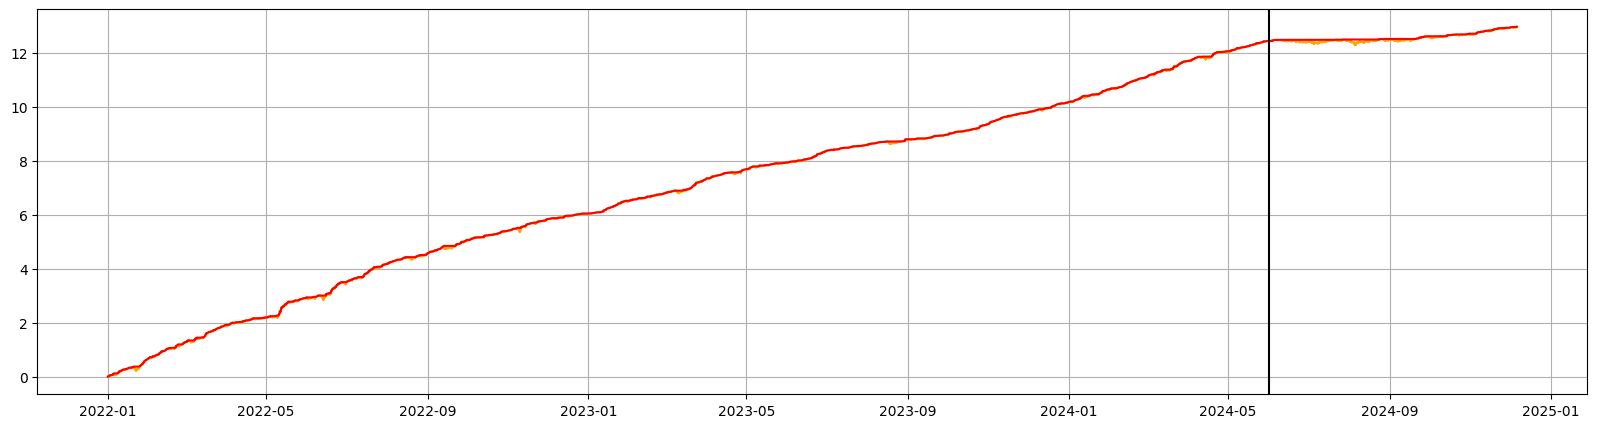

In [9]:
testDate = pd.to_datetime("2024-06-01 00:00:00")

df_temp = func_train_model('dt',df,testDate)
sharpe = func_model_performance(df_temp)
func_plot(df_temp)

In [10]:
for model_type in ["lr","dt","lr_reg","lr_cor","lr_rfe","elnet","lr_ig","rf"]:
  print('----------',model_type,'----------')
  df_temp = func_features(df)
  df_temp = func_train_model(model_type,df_temp,testDate)
  sharpe = func_model_performance(df_temp)

---------- lr ----------
(21167, 70) (4521, 70)
(21167, 25) (21167,)
[ 1.39387356e-05  5.31841931e-05 -2.46524440e-05  2.07163571e-02
  7.34526541e-05 -5.81051530e-05 -7.12875042e-05 -1.15639644e-04
  4.11978065e-05 -5.31794322e-06  3.68069878e-05 -7.71567305e-05
 -1.39604897e-04  2.68504932e-04  1.84840864e-05  1.83220575e-04
 -4.96958146e-04  1.46393230e-05 -1.77393048e-05  3.21904086e-04
 -1.53484545e-05  7.95876491e-05  5.66747498e-05 -6.83026064e-05
 -1.98133813e-05]
            train     test
PNL      : 4.431727   0.239814  
MDD      : 0.322956   0.580556  
Sharpe   : 13.722386  0.413076  
---------- dt ----------
            train     test
PNL      : 12.438153  0.532829  
MDD      : 0.159572   0.210872  
Sharpe   : 77.946964  2.526789  
---------- lr_reg ----------
            train     test
PNL      : 4.374609   0.216748  
MDD      : 0.322956   0.576172  
Sharpe   : 13.545526  0.376186  
---------- lr_cor ----------
            train     test
PNL      : 3.190195   0.20811   
MD

In [11]:
def objective(trial, testDate, df):
    max_depth = trial.suggest_int("max_depth", 3, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)

    params = {
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "random_state": 0
    }

    df_temp = func_features(df.copy())
    df_temp = func_train_model("dt", df_temp, testDate, params)
    sharpe = func_model_performance(df_temp)

    return sharpe

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, testDate, df), 
              n_trials=50, 
              timeout=600, 
              show_progress_bar=True)

print("Лучшие гиперпараметры:", study.best_params)
print("Лучший коэффициент Шарпа:", study.best_value)

[I 2024-12-06 12:06:27,053] A new study created in memory with name: no-name-e14f10cf-5635-4493-b9f5-da1ea2de1b8a


  0%|          | 0/50 [00:00<?, ?it/s]

            train     test
PNL      : 4.924289   0.657421  
MDD      : 0.209618   0.230529  
Sharpe   : 23.491728  2.851793  
[I 2024-12-06 12:06:27,232] Trial 0 finished with value: 23.491728 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 23.491728.
            train     test
PNL      : 0.929272   0.630145  
MDD      : 0.477808   0.209913  
Sharpe   : 1.944865   3.001934  
[I 2024-12-06 12:06:27,407] Trial 1 finished with value: 1.944865 and parameters: {'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 0 with value: 23.491728.
            train     test
PNL      : 6.912277   0.536602  
MDD      : 0.233421   0.234071  
Sharpe   : 29.612918  2.292475  
[I 2024-12-06 12:06:27,594] Trial 2 finished with value: 29.612918 and parameters: {'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 1}. Best is trial 2 with value: 29.612918.
            train     test
PNL      : 4.809913   0.666382 

In [ ]:
params = {
        "max_depth": 15,
        "min_samples_split": 3,
        "min_samples_leaf": 2,
        "random_state": 0
    }

            train     test
PNL      : 9.626295   0.635269  
MDD      : 0.191448   0.193191  
Sharpe   : 50.281512  3.288295  


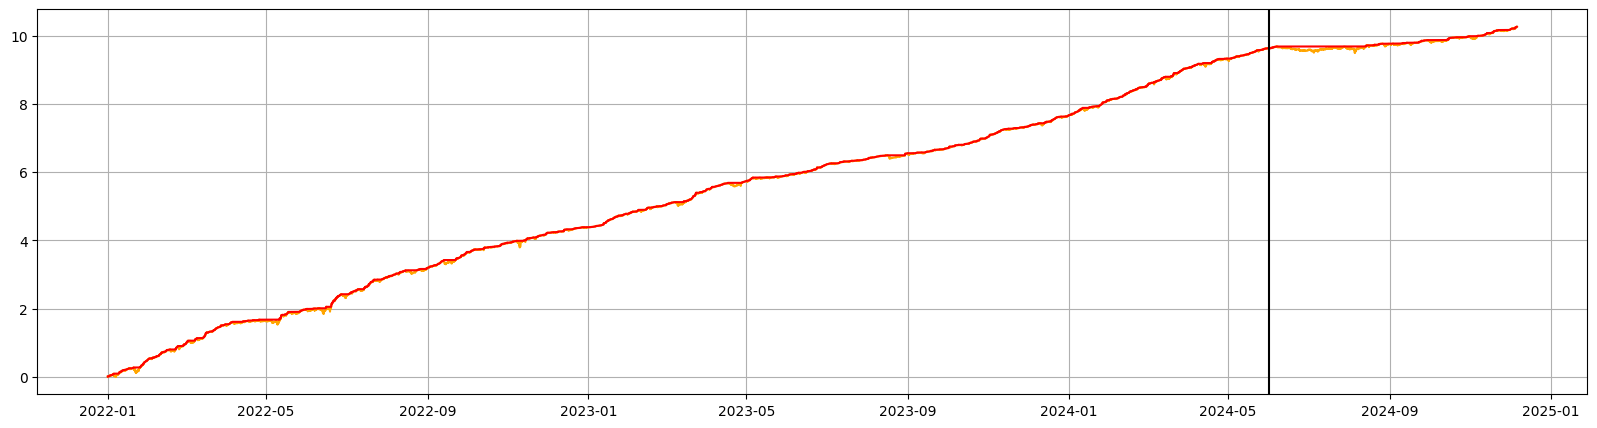

In [16]:
df_best = func_train_model("dt", df_temp, testDate, params)
func_model_performance(df_best)
func_plot(df_best)